In [1]:
import pandas as pd
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from matplotlib import pyplot as plt

# Import Mobility Data

In [2]:
def get_state_mobility_data(state_name):
    all_data = pd.read_csv('../data/mobility/googlereport.csv', low_memory=False)
    state_raw_data = all_data[all_data['sub_region_1'] == state_name]
    
    del all_data
    
    state_data_list = []
    for d in state_raw_data['date'].unique():
        raw_date_data = state_raw_data[state_raw_data['date']==d]
        raw_date_data = raw_date_data[
                [
                    'retail_and_recreation_percent_change_from_baseline', 
                    'grocery_and_pharmacy_percent_change_from_baseline', 
                    'parks_percent_change_from_baseline', 
                    'transit_stations_percent_change_from_baseline', 
                    'workplaces_percent_change_from_baseline', 
                    'residential_percent_change_from_baseline'
                ]
        ].mean(axis=0)

        state_data_list.append({
            'date': d,
            'retail_and_recreation_percent_change_from_baseline': raw_date_data['retail_and_recreation_percent_change_from_baseline'], 
            'grocery_and_pharmacy_percent_change_from_baseline': raw_date_data['grocery_and_pharmacy_percent_change_from_baseline'], 
            'parks_percent_change_from_baseline': raw_date_data['parks_percent_change_from_baseline'], 
            'transit_stations_percent_change_from_baseline': raw_date_data['transit_stations_percent_change_from_baseline'], 
            'workplaces_percent_change_from_baseline': raw_date_data['workplaces_percent_change_from_baseline'], 
            'residential_percent_change_from_baseline': raw_date_data['residential_percent_change_from_baseline']
        })

    df = pd.DataFrame(state_data_list)
    return df

In [3]:
def get_averaged_mobility_data(state_data, average_period=7):
    m = []
    for i, row in state_data.iterrows():
        end = i
        start = max(end - 7, 0)
        window = state_data.loc[start:end]
        m.append({
            'date': row['date'],
            'retail_and_recreation_percent_change_from_baseline': window['retail_and_recreation_percent_change_from_baseline'].mean(), 
            'grocery_and_pharmacy_percent_change_from_baseline': window['grocery_and_pharmacy_percent_change_from_baseline'].mean(), 
            'parks_percent_change_from_baseline': window['parks_percent_change_from_baseline'].mean(), 
            'transit_stations_percent_change_from_baseline': window['transit_stations_percent_change_from_baseline'].mean(), 
            'workplaces_percent_change_from_baseline': window['workplaces_percent_change_from_baseline'].mean(), 
            'residential_percent_change_from_baseline': window['residential_percent_change_from_baseline'].mean()
        })
    
    return pd.DataFrame(m)


# Import Coronavirus Data

In [4]:
def get_state_covid_data(state_name, population):
    raw_data = pd.read_csv('../data/covid19/us.csv')
    state_data = raw_data[raw_data['state']==state_name].copy()
    state_data['new_cases'] = state_data['total_confirmed'].diff()
    state_data['active_cases'] = state_data['total_confirmed'].diff(14)
    state_data['infection_rate'] = (population * state_data['new_cases']) / state_data['active_cases']
    state_data = state_data.fillna(method='bfill')
    
    sus = population - raw_data['total_confirmed'][0]

    m = []
    for i, row in state_data.iterrows():
        sus = sus - row['new_cases']
        m.append({
            'date': row['date'],
            'active_cases': row['active_cases'],
            'new_cases': row['new_cases'],
            'infection_rate': row['infection_rate'] / sus,
        })

    return pd.DataFrame(m)

# Predictions

In [5]:
def get_unified_data(state_name, population):
    mobility_data = get_state_mobility_data(state_name)
    averaged_mobility_data = get_averaged_mobility_data(mobility_data)
    covid_data = get_state_covid_data(state_name, population)
    
    return pd.merge(averaged_mobility_data, covid_data, on='date')

In [6]:
def get_train_data(state_name, population):
    data = get_unified_data(state_name, population)
    y = data['infection_rate']
    x = data.iloc[:, 2:-3]
    
    return x, y, data

In [7]:
def prediction_nn(x, y):
    model = MLPRegressor(hidden_layer_sizes=(3,), activation='relu', max_iter=10000)
    model.fit(x, y)
    return model.predict(x)

In [8]:
def prediction_svm(x, y):
    model = SVR(kernel='rbf')
    model.fit(x, y)
    return model.predict(x)

In [9]:
def plot_data_charts(udata):
    fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, constrained_layout=True, sharex=True, figsize=(15,12))
    
    ax1.plot(udata['retail_and_recreation_percent_change_from_baseline'], udata['infection_rate'])
    ax2.plot(udata['grocery_and_pharmacy_percent_change_from_baseline'], udata['infection_rate'])
    ax3.plot(udata['parks_percent_change_from_baseline'], udata['infection_rate'])
    ax4.plot(udata['transit_stations_percent_change_from_baseline'], udata['infection_rate'])
    ax5.plot(udata['workplaces_percent_change_from_baseline'], udata['infection_rate'])
    ax6.plot(udata['residential_percent_change_from_baseline'], udata['infection_rate'])
    
    plt.show()

In [10]:
def plot_results(predictions, y):
    plt.plot(y.index, y, color='red', label='real')
    plt.plot(y.index, predictions, color='blue', label='predictions')
    plt.legend()
    plt.show()

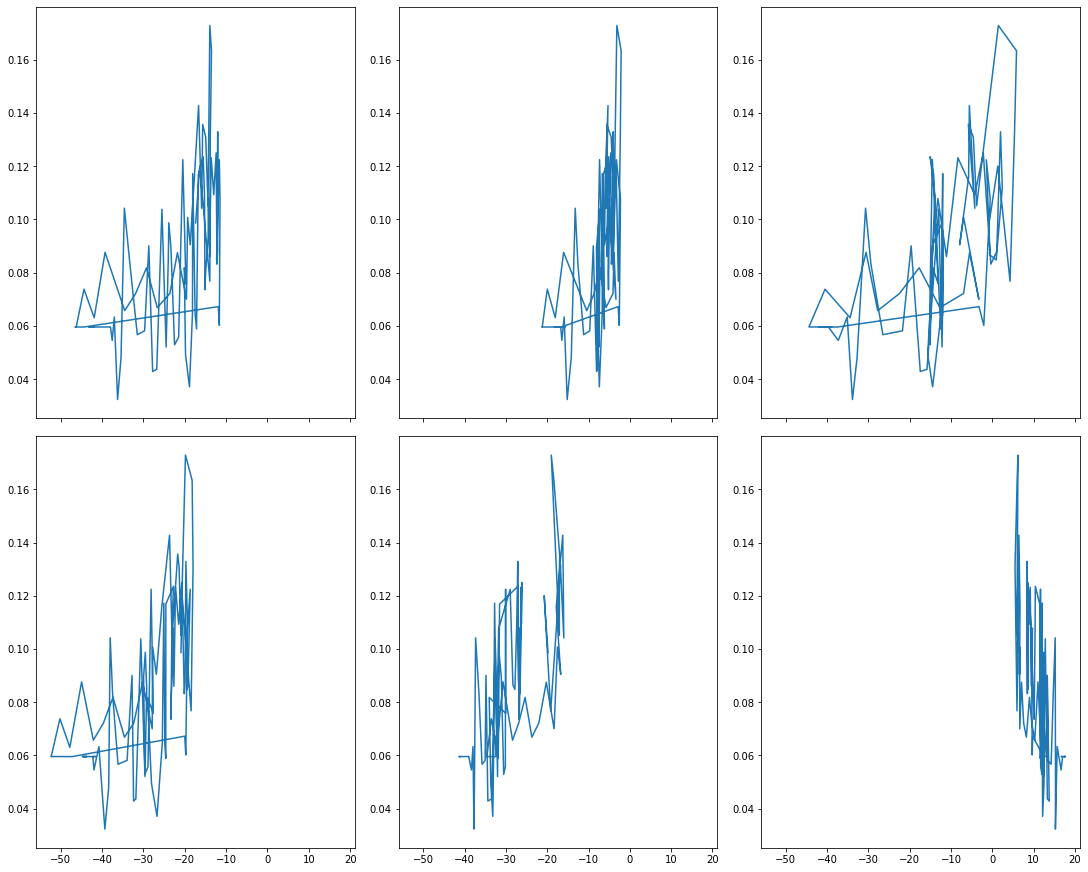

In [32]:
udata = get_unified_data(STATE_NAME, POPULATION)
plot_data_charts(udata)

# SIR Using Predictions (and without)

In [63]:
def sir(population, initial_infected, initial_dead, beta, gamma, rounds=100):
    index = [0]
    susceptiple = [population - initial_infected]
    infected = [initial_infected]
    dead = [initial_dead]
    
    for t in range(1, rounds):
        index.append(t)
        new_infected = beta * (susceptiple[t-1]/population) * infected[t-1]
        new_dead = gamma * infected[t-1]
        susceptiple.append(susceptiple[t-1] - new_infected)
        infected.append(infected[t-1] + new_infected - new_dead)
        dead.append(dead[t-1]+new_dead)
        
    return pd.DataFrame({'date_number': index, 'susceptiple': susceptiple, 'infected': infected, 'removed': dead}, index=index)        

In [64]:
def adv_sir(population, initial_infected, initial_dead, adv_beta, gamma, rounds=100):
    index = [0]
    susceptiple = [population - initial_infected]
    infected = [initial_infected]
    dead = [initial_dead]
    
    for t in range(1, rounds):
        index.append(t)
        new_infected = adv_beta[t-1] * (susceptiple[t-1]/population) * infected[t-1]
        new_dead = gamma * infected[t-1]
        susceptiple.append(susceptiple[t-1] - new_infected)
        infected.append(infected[t-1] + new_infected - new_dead)
        dead.append(dead[t-1]+new_dead)
        
    return pd.DataFrame({'date_number': index, 'susceptiple': susceptiple, 'infected': infected, 'removed': dead}, index=index)        

In [76]:
STATE_NAME = 'Washington' # 'New York'
POPULATION = 7.5e6 # 19.5e6

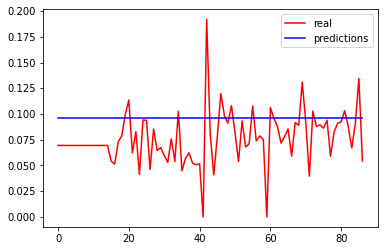

In [77]:
x, y, data = get_train_data(STATE_NAME, POPULATION)
predictions = prediction_svm(x, y)
predictions2 = prediction_nn(x, y)
plot_results(predictions, y)

In [78]:
initial_infected = data['active_cases'][0]

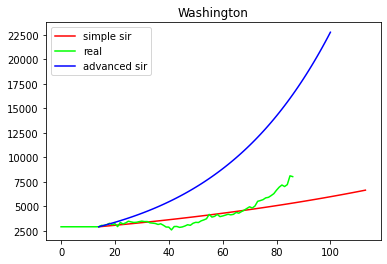

2912.0

In [85]:
simple_sir_predictions = sir(POPULATION, initial_infected, 0, 0.080, 1/14, 100)
adv_sir_predictions = adv_sir(POPULATION, initial_infected, 0, predictions, 1/14, len(predictions))

plt.plot(simple_sir_predictions.index + 14, simple_sir_predictions['infected'], color='#f00', label='simple sir')

plt.plot(data.index, data['active_cases'], color='#0f0', label='real')

plt.plot(adv_sir_predictions.index + 14, adv_sir_predictions['infected'], color='#00f', label='advanced sir')
plt.title(STATE_NAME)
plt.legend()
plt.show()

data['active_cases'][0]